<div><a href="https://knodis-research-group.github.io/"><img style="float: right; width: 128px; vertical-align:middle" src="https://knodis-research-group.github.io/knodis-logo_horizontal.png" alt="KNODIS logo" /></a>

# Creación y visualización de _embeddings_<a id="top"></a>

<i><small>Última actualización: 2025-03-14</small></i></div>

***

## Introducción

Los _embeddings_ son una técnica utilizada para representar datos de forma más compacta y significativa. En concreto, se utilizan para representar vectores de dimensiones muy grandes (por ejemplo, representaciones de palabras o imágenes) en espacios de mucha menor dimensión (normalmente unas pocas decenas o centenares de ellas).

Son muy útiles en aplicaciones de aprendizaje automático relacionadas con el procesamiento del lenguaje natural. Por ejemplo, pueden utilizarse para representar palabras en un espacio vectorial, de modo que las palabras que tienen un significado similar se representen cerca unas de otras. Esto es útil en tareas como la traducción automática, en la que se busca la palabra en la lengua de destino que tenga el significado más parecido a la palabra en la lengua de origen.

## Objetivos

En este cuaderno crearemos un Embedding y lo proyectaremos en un espacio bidimensional para probar cómo se pueden relacionar las palabras en un espacio vectorial en un contexto dado (problema).

Entrenaremos este embedding para una tarea de clasificación típicamente utilizada para empezar a aprender NLP, la de análisis de sentimiento de los comentarios de IMDb. Sin embargo, nos quedaremos en el punto en el que se entrena el _embedding_, dejando el análisis de sentimiento para más adelante.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import collections
import re

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics

import utils

Using device: cuda


También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
np.set_printoptions(precision=3)

plt.style.use('bmh')
plt.rcParams.update({'figure.figsize': (16, 9),'figure.dpi': 100})

Por último, establecemos las constantes de los recursos comunes.

In [3]:
BATCH_SIZE = 8192
EMBEDDING_DIM = 3
MAX_VOCAB_SIZE = 65535
MAX_SEQUENCE_LEN = 128
TRAIN_EPOCHS = 50

***

## Preparando nuestro conjunto de datos

Vamos a utilizar el dataset [_Large Movie Review Dataset_](https://ai.stanford.edu/~amaas/data/sentiment/) para _sentiment analysis_ como fuente de datos. En este caso vamos a hacer uso de la biblioteca `datasets` de Hugging Face, que ofrece un interfaz muy cómodo para descargar conjuntos de datos del sitio.

In [4]:
dataset = datasets.load_dataset('imdb')
# Primera frase de ejemplo
text = dataset['train'][0]['text']
label = dataset['train'][0]['label']
print(f"Train example: {text}--- -> {label}")

Train example: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and f

Al ser los ejemplos de entrada cadenas de texto, tenemos que definir alguna forma de identificar los diferentes _tokens_ que los conforman. Para ello nos definiremos una función que convertirá las cadenas en sus _tokens_.

In [5]:
def text_tokenizer(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b|[^\w\s]', text, re.UNICODE)
    return tokens

text_sentence = "The best sentence of the world."
tokens_sentence = text_tokenizer(text_sentence)
print(f"Sentence: {text_sentence} -> Tokens {tokens_sentence}")

Sentence: The best sentence of the world. -> Tokens ['the', 'best', 'sentence', 'of', 'the', 'world', '.']


No es el mejor _tokenizador_, pero nos hace el apaño. Ahora usaremos esta función para extraer todos los tokens que conforman todos los comentarios y su frecuencia absoluta. De esta manera, podremos determinar qué palabras son las más comunes y por tanto cuáles son las que más nos interesa conservar.

In [6]:
counter = collections.Counter()
for example in dataset['train']:
    list_of_tokens = text_tokenizer(example['text'])
    counter.update(list_of_tokens)
counter.most_common(10)

[('the', 336749),
 ('.', 327192),
 (',', 276280),
 ('and', 164140),
 ('a', 163123),
 ('of', 145864),
 ('to', 135724),
 ("'", 133857),
 ('/', 108798),
 ('is', 107332)]

A la lista de tokens se les añade normalmente una serie de tokens especiales que se usan para manejar situaciones particulares durante el procesamiento de texto. Nosotros añadiremos los típicos:

- `<PAD>`: Se utiliza para _padding_, esto es, para rellenar secuencias de diferente longitud y poder procesarlas en batches de tamaño fijo, agregando este token hasta alcanzar una longitud deseada.
- `<SOS>`: _Start Of Sentence_ (comienzo de la oración), el cual se usa para indicar explícitamente el comienzo de una secuencia. Es útil en la generación de texto o modelos de secuencia a secuencia (_seq2seq_).
- `<UNK>`: Utilizado para los casos en los que encontramos una palabra que no está en nuestro vocabulario (_unknown_). Así, cualquier palabra no reconocida se mapea a este token.
- `<UNU>`: Esta no es tan común, y sirve para reservar un índice en el vocabulario para posibles usos futuros o para mantener compatibilidad con algunos modelos o datasets que lo requieran (_unused_).

In [7]:
special_tokens = ['<PAD>', '<SOS>', '<UNK>', '<UNU>']

Ahora, con todos los _tokens_ definidos, pasaremos a quedarnos con los que más nos interesen (en principio los más comunes). A estos tokens se les denominará «vocabulario», y será la lista de tokens que nuestros modelos usarán. Además, cada uno de los tokens llevará asociado un índice que represetará a dicho token en las entradas y salidas del modelo qué los usen.

In [8]:
# Tomamos la lista de tokens más comunes, guardando sitio para los especiales
most_common = counter.most_common(MAX_VOCAB_SIZE - len(special_tokens))

# Metemos primero los tokens especiales y después los tokens más comunes
vocabulary = {token: idx for idx, token in enumerate(special_tokens)}
for idx, (token, count) in enumerate(most_common, start=len(special_tokens)):
    vocabulary[token] = idx

# Creamos también el diccionario inverso para mapear índices a palabras
index_to_token = {idx: word for word, idx in vocabulary.items()}

print(f"Vocabulary size: {len(vocabulary)}")

Vocabulary size: 65535


Nuestras listas de tokens de entrada están compuestas de tokens, no de números, y los modelos requieren entradas numéricas (en nuestro caso enteros porque serán índices a vectores). Vamos a crear una función que pase de texto a lista de índices, usando para ello nuestra función previa, `text_tokenizer`.

Esta función será usada por nuestra siguiente función, preprocess_dataset, que tomará el conjunto de entrada descargado y devolverá las listas de índices a tokens.

Vale, esto ya es otra cosa. Ahora, vamos a por el primer problema de todos. Para obtener una entrada de longitud fija, podemos simplemente truncar las reseñas a un número fijo de palabras, digamos 64. Para las reseñas de más de 64 palabras, conservaremos sólo las primeras 64 palabras. En el caso de las opiniones de más de 64 palabras, sólo conservaremos las 64 primeras. Para las reseñas más cortas, rellenaremos los huecos de palabras no utilizadas con el valor que hayamos asignado al relleno (el 0). Con keras, esto es fácil de hacer usando la función `pad_sequences`:

In [9]:
def prepare_dataset(dataset, fn_tokenizer, vocabulary, max_len, with_sos=False):
    UNK = vocabulary['<UNK>']
    
    data = []
    for entry in dataset:
        # 1. Tokenizamos el comentario, añadiendo <SOS> si es necesario
        sequence = fn_tokenizer(entry['text'])
        if with_sos:
            sequence = ['<SOS>'] + sequence

        # 2. Truncamos la secuencia si es larga o la rellenamos si es corta
        sequence = sequence[:max_len]
        if len(sequence) < max_len:
            sequence = ['<PAD>'] * (max_len - len(sequence)) + sequence

        # 3. Ya podemos pasar a índices. Los codificamos como long para ello
        sequence = torch.tensor(
            [vocabulary.get(token, UNK) for token in sequence],
            dtype=torch.long,
        )

        # 4. Procesamos las salidas que, afortunadamente, ya vienen preparaditas
        #    como 0 (negative) o 1 (positive). Las codificamos como float para
        #    la pérdida
        label = torch.tensor(example['label'], dtype=torch.float)
        data.append((sequence, label))
    return data


Crearemos ahora los dataloaders a partir de un dataset personalizado, tal y como hemos hecho hasta el momento.

In [10]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data  # Lista de tuplas (secuencia, etiqueta)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = SentimentDataset(prepare_dataset(
    dataset=dataset['train'],
    fn_tokenizer=text_tokenizer,
    vocabulary=vocabulary,
    max_len=MAX_SEQUENCE_LEN,
))
test_dataset  = SentimentDataset(prepare_dataset(
    dataset=dataset['test'],
    fn_tokenizer=text_tokenizer,
    vocabulary=vocabulary,
    max_len=MAX_SEQUENCE_LEN,
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Usando la capa `Embedding`

Torch facilita **mucho** el trabajo con _embeddings_ gracias a la capa `torch.nn.Embedding`, que puede entenderse como una capa de tipo `Linear` que mapea desde índices enteros (los índices de las palabras concretas) a vectores de palabras (sus correspondientes _embeddings_).

Los `Embeddings` requieren al menos dos parámetros; el primero (`num_embeddings`), el número de _embeddings_, indica cuántas palabras tendrá en cuenta nuestra capa. Cuanto mayor sea este parámetro, más palabras se podrán representar, pero más memoria ocupará y, sobre todo, más parámetros habrá que entrenar.

El segundo parámetro (`embedding_dim`) es la dimensión de los vectores resultantes. Este parámetro indica el número de características que se almacenarán para cada palabra del _embedding_. Este es el parámetro con el que más se juega cuando se crea una incrustación desde 0 para resolver un problema, del mismo modo que se experimenta con el número de neuronas de una capa `Linear`.

Por ejemplo, vamos a crear un _embedding_ con unas cuantas palabras y una dimensión concreta.

In [11]:
embedding_layer = torch.nn.Embedding(
    num_embeddings=1000,  # Número máximo de tokens a representar
    embedding_dim=5,      # Cuántas dimensiones representa cada ítem
)

Cuando se crea una capa `Embedding`, sus pesos se inicializan aleatoriamente, como con cualquier otra capa. Y también como cualquier otra capa, dichos pesos se ajustarán gradualmente durante el entrenamiento.

Una vez entrenados, cabe esperar que los vectores de palabras aprendidos codifiquen aproximadamente las similitudes entre palabras, ya que, después de todo, se aprendieron para el problema específico sobre el que se entrena el modelo.

Podemos darle un tensor de varios _tokens_ (o un tensor de los mismos) y nos devolverá un tensor, esta vez con $n$ dimensiones más, correspondientes a las $n$ características que codifican los vectores de los embeddings de cada palabra.

In [12]:
result = embedding_layer(torch.LongTensor([
    [0, 1, 2, 3],
    [4, 5, 6, 7],
]))
print(f'Result (shape = {result.shape}):\n{result}')

Result (shape = torch.Size([2, 4, 5])):
tensor([[[-0.9397,  0.1886,  0.2333,  1.8822,  1.1973],
         [-1.2962, -0.6217, -0.0129,  0.7885, -0.7246],
         [-0.1225, -0.2215, -1.5784, -0.7448,  0.8754],
         [ 0.1076,  1.7131,  0.9324,  0.3824, -0.7759]],

        [[ 1.0863, -0.1105, -0.0096,  0.1910,  0.8641],
         [ 1.0106, -0.1287,  0.8352,  1.5350,  0.2062],
         [ 0.1731, -0.4847, -1.3397,  0.2599, -1.2379],
         [ 0.7244,  2.5909,  2.2739, -0.9149, -0.2358]]],
       grad_fn=<EmbeddingBackward0>)


Podemos ver que si damos un _batch_ de secuencias como entrada, una capa `torch.nn.Embedding` devuelve un tensor 3D de tipo `float`, de la forma `(num_sequences, items_per_sequence, embedding_dim)`.

## Entrenamiento del modelo de clasificación

Utilizaremos un modelo secuencial formado por un embedding, un par de capas recurrentes (para ver si son capaces de capturar alguna características, y una capa densa. Este modelo se entrenará para intentar dar respuesta a qué comentarios son negativos y cuáles positivos (clasificación binaria).

Entre todos los pesos que se entrenen, estarán los del `Embedding`. Una vez finalizado el entrenamiento, nuestro `Embedding` tendrá una comprensión de las relaciones que existen entre nuestras palabras, al menos dentro de nuestro contexto de comentarios positivos o negativos a nuestras películas.

In [13]:
class SentimentRNN(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, pad_idx):
        super().__init__()

        self.embedding = torch.nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=pad_idx,  # El índice para el <PAD>. Por defecto 0.
        )
        # Capas recurrentes
        self.gru = torch.nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=3,
            batch_first=True,
        )
        # Capa lineal para la salida final
        self.fc = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        embedded = self.embedding(x)  # (B, SEQ_LEN) -> (B, SEQ_LEN, EMBED_DIM)
        out, _ = self.gru(embedded)
        out = out[:,-1,:]
        out = self.fc(out)
        out = torch.squeeze(out, 1)   # (B, 1) -> (B,)
        return out

# Instanciar el modelo
model = SentimentRNN(
    vocab_size=len(vocabulary),
    embed_dim=EMBEDDING_DIM,  # Así podemos visualizarlo en 3D
    hidden_dim=8,
    pad_idx=vocabulary['<PAD>'],
)
print(model)

SentimentRNN(
  (embedding): Embedding(65535, 3, padding_idx=0)
  (gru): GRU(3, 8, num_layers=3, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


Y ahora entrenamos el modelo.

In [14]:
history = utils.train(
    model=model,
    train_loader=train_loader,
    n_epochs=TRAIN_EPOCHS,
    criterion=torch.nn.BCEWithLogitsLoss(),
    optimizer=torch.optim.Adam(model.parameters()),
    validation_split=0.1,
)

Epoch 1/50 (4.37s), Train loss: 0.6753, Val loss: 0.6615
Epoch 2/50 (4.45s), Train loss: 0.6552, Val loss: 0.6411
Epoch 3/50 (4.57s), Train loss: 0.6347, Val loss: 0.6202
Epoch 4/50 (4.60s), Train loss: 0.6136, Val loss: 0.5987
Epoch 5/50 (4.48s), Train loss: 0.5919, Val loss: 0.5764
Epoch 6/50 (4.34s), Train loss: 0.5694, Val loss: 0.5533
Epoch 7/50 (4.61s), Train loss: 0.5460, Val loss: 0.5294
Epoch 8/50 (4.72s), Train loss: 0.5218, Val loss: 0.5046
Epoch 9/50 (4.55s), Train loss: 0.4969, Val loss: 0.4793
Epoch 10/50 (4.59s), Train loss: 0.4715, Val loss: 0.4537
Epoch 11/50 (4.72s), Train loss: 0.4458, Val loss: 0.4281
Epoch 12/50 (4.87s), Train loss: 0.4203, Val loss: 0.4028
Epoch 13/50 (4.60s), Train loss: 0.3953, Val loss: 0.3784
Epoch 14/50 (4.69s), Train loss: 0.3712, Val loss: 0.3551
Epoch 15/50 (4.68s), Train loss: 0.3484, Val loss: 0.3334
Epoch 16/50 (4.59s), Train loss: 0.3272, Val loss: 0.3134
Epoch 17/50 (4.66s), Train loss: 0.3078, Val loss: 0.2952
Epoch 18/50 (4.67s), Tr

Veamos la evolución del entrenamiento para comprobar que el modelo está aprendiendo.

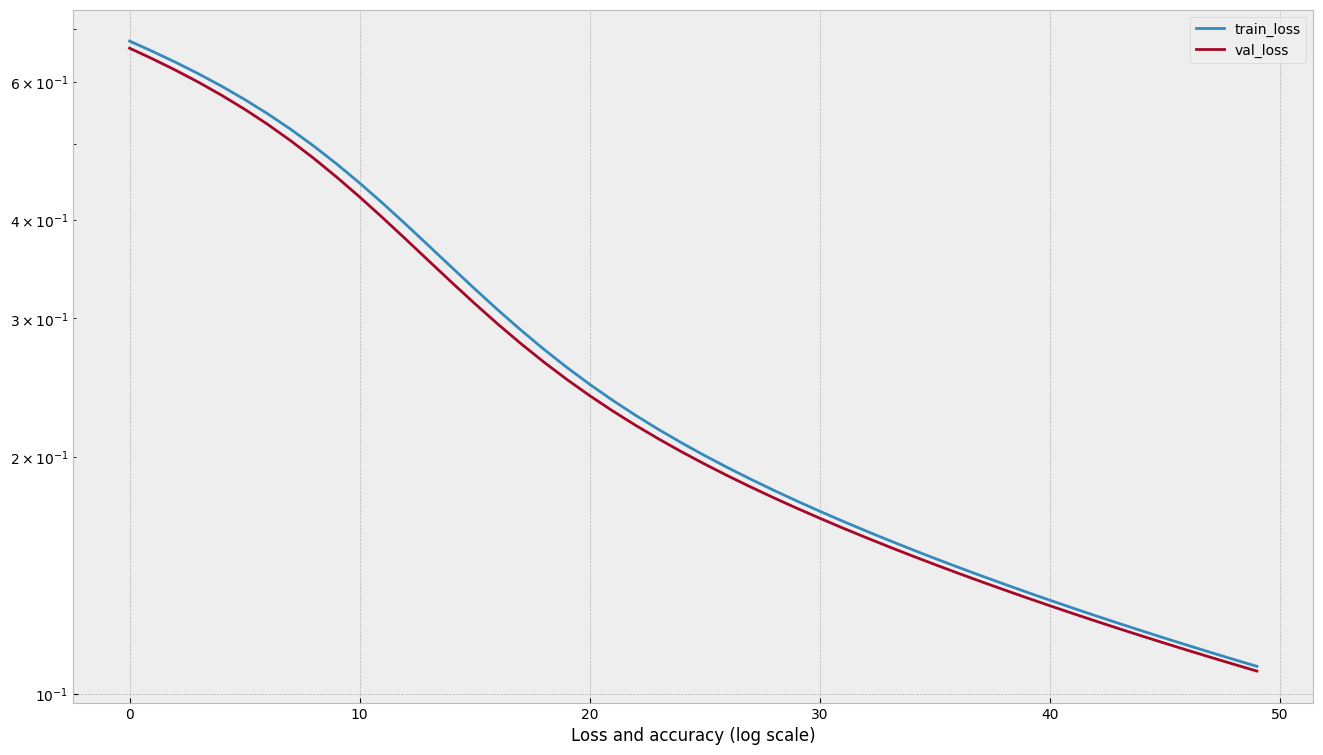

In [15]:
pd.DataFrame(history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.xlabel('Loss and accuracy (log scale)')
plt.show()

## Visualización del embedding

Vamos a ver la representación que hace de ciertas palabras nuestro modelo:

In [16]:
model.eval()
with torch.no_grad():
    sample_seq, _ = test_dataset[0]
    embedding_output = model.embedding(sample_seq)
    embedding_output = embedding_output.squeeze(0).numpy()

print(f"Sample sequence: {sample_seq}")
print(f"Input shape:     {sample_seq.numpy().shape}")
print(f"Embedding shape: {embedding_output.shape}")

Sample sequence: tensor([   19,   133,   929,    22,   927,     7,   263,  1708,    10,   293,
           71,    28,     8,   193,     5,   929,    22,   927,   115,    12,
          262,    39,   646, 43828,     6,   484,    22,  2553,     7,  7172,
            5,    19,   814,    10,    53,    20,     6,    19,    80,   138,
            6,    30,    17,    13,    10,    65,   262,   929,    22,   927,
           26, 15068,   472,    13,    10,   340,  2051,    33,     4,   220,
           32,     5,   723, 18654,     6,   721,  3488,   745,     6,  4618,
         4017,     6,  4497,    21,   169,    11,    34,  1024,     4,   986,
            6,     7,  2176,    43,    22,  2074,   119,   580,    42,  3103,
           28,     8,    11,   929,    22,   927,    11,   962,     5,    33,
           19,    11,   160,   270,    54,    39,   165,     9,    35,    59,
           54,    50,   118, 15068,   472,    13,    65,   929,    22,   927,
          262,     5,    17,    11,    24,    3

Podemos observar que, dada una secuencia, la salida de nuestro _embedding_ es una lista de un único tensor con la secuencia de salida

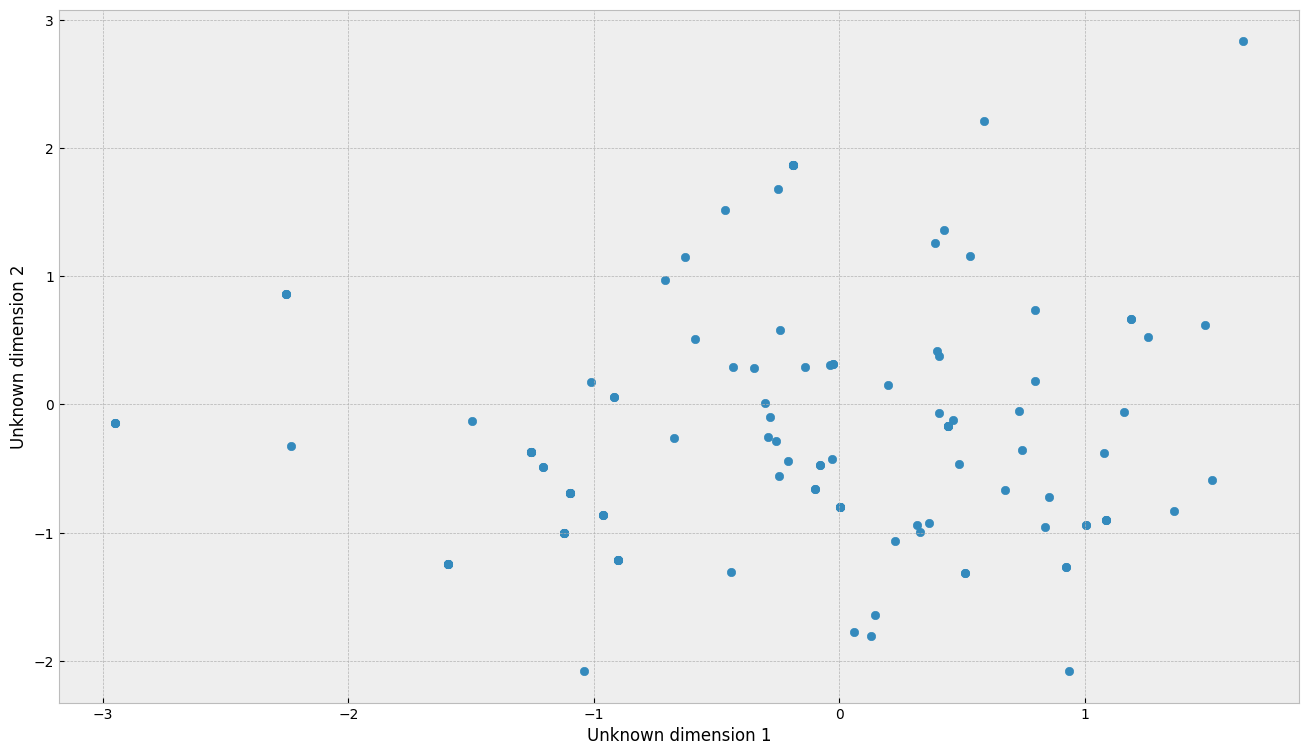

In [17]:
plt.figure()
plt.scatter(embedding_output[:, 0], embedding_output[:, 1])
plt.xlabel('Unknown dimension 1')
plt.ylabel('Unknown dimension 2')
plt.show()

Echemos un ojo a los vectores de los pesos asociados a determinadas palabras

In [18]:
embedding_weights = model.embedding.weight.detach().numpy()
df_weights = pd.DataFrame(
    embedding_weights,
    index=[index_to_token.get(i, '<UNK>') for i in range(len(vocabulary))]
)

df_weights.loc[['reeves', 'seagal', 'curtis', 'megan', 'horrible', 'man', 'woman', 'potato', 'rotten'],:]

,0,1,2
reeves,-0.764582,-0.022727,1.029633
seagal,-1.135360,-0.800834,-0.090328
curtis,0.773483,-1.824866,0.025851
megan,-1.012585,-0.724974,0.094903
horrible,-0.600836,-0.169766,1.769226
man,-0.194414,0.318505,0.869546
woman,-0.439987,0.800089,0.881418
potato,-0.872943,-1.702353,-0.448546
rotten,0.539113,-0.486053,0.111702


Vamos a probar una cosa. Crearemos una reseña ficticia y veremos cómo se distribuyen las palabras en el espacio bidimensional que hemos creado.

In [19]:
review = ['cage', 'reeves', 'seagal', 'cavill', 'good', 'matrix', 'bad', 'crap',
          'affleck', 'man', 'woman', 'king', 'queen', 'curtis', 'megan', 'potato']

encoded_review = [vocabulary.get(word, vocabulary['<UNK>']) for word in review]
encoded_review_tensor = torch.tensor(encoded_review, dtype=torch.long)
print("Reseña codificada:", encoded_review_tensor.numpy())

Reseña codificada: [ 1829  5657  3075     2    65  2546    92   607  5970   143   260   630
  1594  3300 10328 13511]


Ahora veamos la salida de `Embedding` si le damos a revisar:

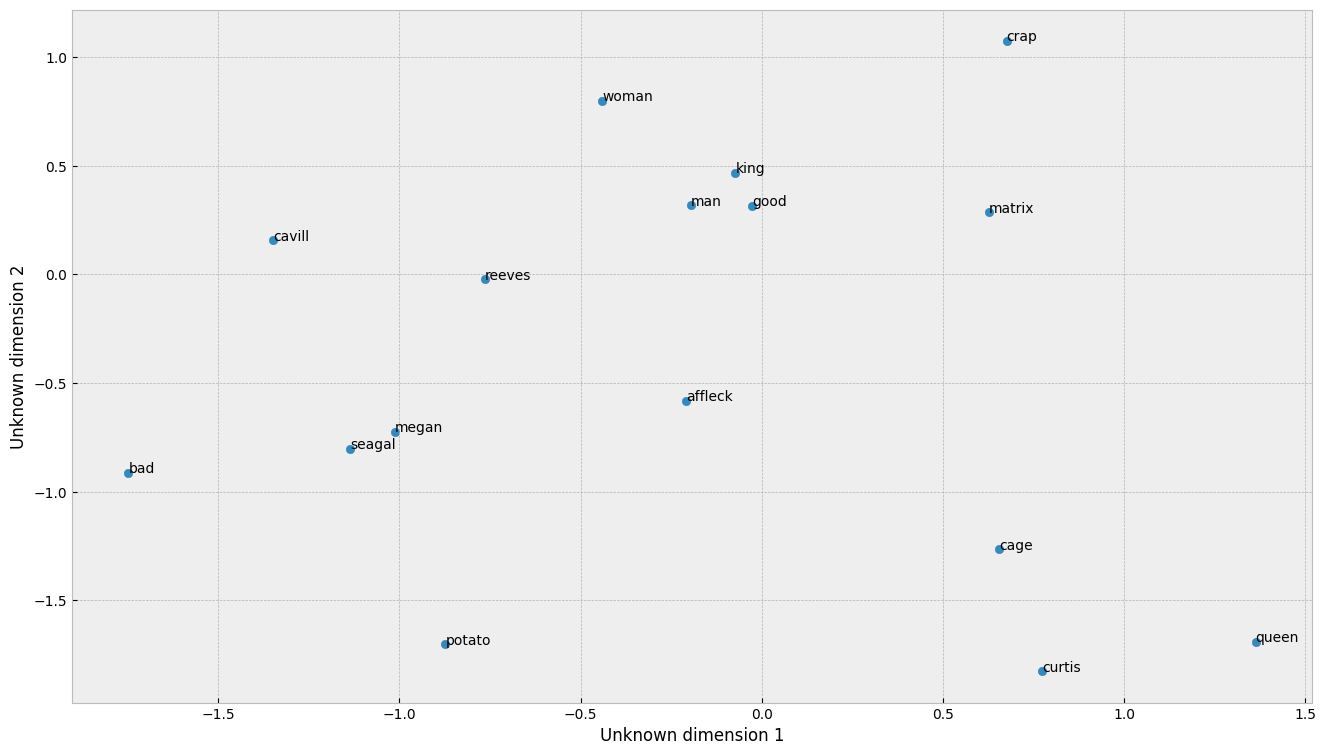

In [20]:
# Obtener los vectores de embedding para cada palabra de la reseña
with torch.no_grad():
    review_embeddings = model.embedding(encoded_review_tensor.unsqueeze(0))  # (1, len(review), embed_dim)
    review_embeddings = review_embeddings.squeeze(0).numpy()  # (len(review), embed_dim)

# Graficar los embeddings de la reseña y anotar cada punto con su palabra
plt.scatter(review_embeddings[:, 0], review_embeddings[:, 1])
for i, word in enumerate(review):
    plt.text(review_embeddings[i, 0], review_embeddings[i, 1], word)
plt.xlabel('Unknown dimension 1')
plt.ylabel('Unknown dimension 2')
plt.show();

In [21]:
eval = utils.evaluate(
    model=model,
    data_loader=test_loader,
    criterion=torch.nn.BCEWithLogitsLoss(),
    metric_fn=torchmetrics.classification.BinaryAccuracy(),
)
print(f'Results -> Loss: {eval.get("loss")}, Acc: {eval.get("metric")}')

Results -> Loss: 0.10694645022630692, Acc: 1.0


Vemos que, en principio, nuestro `embedding` ha localizado espacialmente las palabras que están más relacionadas. De este modo, podemos identificar qué actores están más cerca de qué calificadores en función de su proximidad a ellos

## Conclusiones

Hemos creado una incrustación a partir de ciertos datos y demostrado cómo puede crear una representación en un espacio vectorial de las palabras incluidas en ella. Esta representación permite agrupar en el espacio vectorial palabras que tienen significados similares, lo que puede ser útil para tareas de análisis de textos como la clasificación de documentos o la búsqueda de información. También hemos mostrado cómo la incrustación puede utilizarse para realizar tareas como la identificación de palabras desconocidas y la detección de palabras mal escritas.

En general, el uso de incrustaciones para representar datos de texto es una técnica valiosa en el aprendizaje automático y el procesamiento del lenguaje natural. Permiten representar las palabras de forma más significativa en un espacio vectorial, lo que facilita la identificación de patrones y la realización de tareas de clasificación y predicción. Además, su capacidad para agrupar palabras similares en un espacio vectorial puede mejorar significativamente la precisión y la eficacia de los modelos de análisis de texto.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>